In [36]:
import torch
import math
#from dlc_practical_prologue import *
#torch.set_grad_enabled(False)

In [37]:
#INTERESTING FACT: WHEN COMPUTING THE BATCH GRADIENT PYTORCH DOES NOT TAKE THE SUM OF THE GRADIENTA OF SINGLE DATA POINTS
#BUT THE MEAN. I LEART AT THE EXPENSE OF ABOUT 1H LOL 

In [38]:
class Parameter():
    def __init__(self):
        self.name = ''
        self.data = None
        self.grad = None

In [39]:
class Module(object):
    def forward (self, *input):
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
    
    def get_parameters( self ) :
        return []   

In [40]:
class Losses(object):        
    def forward():
        return NotImplementedError
    def backward():
        NotImplementedError

In [41]:
class Optimizer(object):
    def zero_grad(self):
        for parameter in self.param : 
            parameter.grad = 0
            
    def step(self):
        raise NotImplementedError

In [42]:
class SGD(Optimizer):

    def __init__(self,lr, parameters, momentum = True ,beta= 0.9) :   
        super().__init__()
        self.eta = lr   # learning rate is fixed
        self.param = parameters
        # Initialize momentum to zero
        self.v = self.param.copy()
        self.v = []
        for i in range(len(self.param)):
            size_param = self.param[i].data.size()
            v_init= torch.zeros(size_param)
            (self.v).append(v_init)
        self.beta = beta
        self.momentum = momentum

    def step(self): 
        for parameter, V in zip(self.param, self.v): 
            if self.momentum :    # SGD + Momentum
                V = self.beta * V + self.eta * parameter.grad   
                parameter.data = parameter.data - V
            else :                # SGD 
                parameter.data = parameter.data - self.eta * parameter.grad
           
        return self.param

In [43]:
class Linear(Module):
    
    def __init__(self, input_dim, out_dim, bias = True):
        super().__init__()
        std = 1/math.sqrt(input_dim)
        self.weight = Parameter()
        self.parameters = []
        
        self.weight.data = torch.rand(out_dim, input_dim)
        self.weight.data = 2*std*self.weight.data - std
        self.weight.name = 'weight'
        self.parameters += [self.weight]
        
        self.with_bias = bias
        if bias :
            self.bias = Parameter()
            self.bias.data = torch.rand(out_dim)
            self.bias.data = 2*std*self.bias.data - std
            self.bias.data = self.bias.data.unsqueeze(0)
            self.bias.name = 'bias'
            self.parameters +=[self.bias]
            
        self.x = None
              
    def forward(self, x):
        self.x = x
        self.batch_size = x.shape[0]
        return self.x.mm(self.weight.data.T) + self.bias.data
        
    def backward(self, prev_grad):
        
        prev_grad = prev_grad.view(self.batch_size, -1, 1)
        #print(prev_grad.shape)
        if self.x is None:
            raise CallForwardFirst
        
        if self.weight.grad is None:
            self.weight.grad = torch.zeros_like(self.weight.data)
        
        grad_on_batch = prev_grad.view(self.batch_size, -1, 1)*self.x.view(self.batch_size, 1, -1)
        self.weight.grad += grad_on_batch.mean(0)
        
        if self.with_bias:
            if self.bias.grad is None:
                self.bias.grad = torch.zeros_like(self.bias.data)
            grad_on_batch = prev_grad.view(self.batch_size, -1)
            self.bias.grad += grad_on_batch.mean(0)
        
        #if the output has dimension one, squeezing creates problems
        if prev_grad.shape[1]>1:
            prev_grad = prev_grad.squeeze()
        next_grad = prev_grad@self.weight.data
        return next_grad.squeeze()
    
    def get_parameters(self):
        return self.parameters    

In [44]:
class Tanh(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.tanh(x)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)
        
        return d(self.x)*prev_grad
            

In [45]:
class ReLu(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        x[x<0]=0
        return x
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            x[x<0]=0
            x[x>0]=1
            return x
        
        return d(self.x)*prev_grad
            

In [46]:
#Doesn't work and we have to output 1 unit so it's useless
class Softmax(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.softmax(x,1)     
     
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        
        def d(x):
            s = x.softmax(1)
            temp = s.unsqueeze(-1)
            off_diag = temp*torch.transpose(temp, 1, 2)
            diag = torch.diag_embed(torch.diagonal(off_diag, dim1 = 1, dim2 = 2).sqrt()) 
            return diag - off_diag
        return torch.einsum('b ij, bj -> bi', d(self.x),prev_grad)/ x.shape[0]

In [47]:
#Doesn't work and we have to output 1 unit so it's useless
class Sigmoid(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.sigmoid(x)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            y=torch.sigmoid(x)
            return y*(1-y)
        
        return d(self.x)*prev_grad

In [48]:
class MSE(Losses):
    # Attention! Works well only when the vectors provided are of the form [batch_size, vector dimension]
    # Otherwise it doesn know what dimesion to pick for the mean computation
    # I'll fix this later
    def __init__(self):
        self.x = None
    def forward(self, x, t):
        self.x = x
        self.t = t
        return (x - t).pow(2).mean()
    
    def backward(self):
        if self.x == None or self.t == None:
            raise CallForwardFirst
        return 2 * (self.x - self.t)/(self.x.shape[1]*self.x.shape[0])

In [49]:
class Sequential(object):
    def __init__(self, modules):
        super().__init__()
        self.modules=modules
        self.parameters = []
        for m in self.modules:
            param = m.get_parameters()
            if param:
                self.parameters += param
        
    def forward(self,x):
        for m in self.modules:
            x=m.forward(x)
        return x
    
    def backward(self, loss_grad):
        x = loss_grad
        for m in reversed(self.modules):
            #print(m)
            x = m.backward(x)
            
    def get_parameters(self):
        return self.parameters

    def set_parameters(self , params):
        self.parameters = params
        

In [50]:
############################################################################################################################
################################# CHECK ON SOFTMAX ########################################################################

In [51]:
#check on the fradient od softmax
x = torch.randn(2, 5, requires_grad = True)

def d( x):
    s = x.softmax(1)
    temp = s.unsqueeze(-1)
    off_diag = temp*torch.transpose(temp, 1, 2)
    diag = torch.diag_embed(torch.diagonal(off_diag, dim1 = 1, dim2 = 2).sqrt()) 
    return diag - off_diag   


soft = Softmax()
s_b = x.softmax(1)
s_h = soft.forward(x.clone())
print('check on the values: builtin\n', s_b ,'\n homemade \n', s_h, '\n diff:\n', abs(s_b-s_h) )

selector = 0 #to make the check on one of the tensor in the batches

soft.backward(torch.ones(2, 5))
builtin_soft_der = torch.ones(1, 5)
for i in range(5):
    new = torch.autograd.grad(s_b[selector,i], x, retain_graph = True)[0][selector].unsqueeze(0)
    builtin_soft_der = torch.cat((builtin_soft_der, new), 0 )
builtin_soft_der = builtin_soft_der[1:]
print('builtin derivative on the selected tensor \n', builtin_soft_der)
print('homemade derivative on the whole batch \n', d(x))
print('difference on the selected tensor \n', abs(builtin_soft_der - d(x)[selector].unsqueeze(0)))

check on the values: builtin
 tensor([[0.0858, 0.2152, 0.2297, 0.3066, 0.1628],
        [0.0575, 0.0581, 0.3356, 0.1128, 0.4360]], grad_fn=<SoftmaxBackward>) 
 homemade 
 tensor([[0.0858, 0.2152, 0.2297, 0.3066, 0.1628],
        [0.0575, 0.0581, 0.3356, 0.1128, 0.4360]], grad_fn=<SoftmaxBackward>) 
 diff:
 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], grad_fn=<AbsBackward>)
builtin derivative on the selected tensor 
 tensor([[ 0.0784, -0.0185, -0.0197, -0.0263, -0.0140],
        [-0.0185,  0.1689, -0.0494, -0.0660, -0.0350],
        [-0.0197, -0.0494,  0.1769, -0.0704, -0.0374],
        [-0.0263, -0.0660, -0.0704,  0.2126, -0.0499],
        [-0.0140, -0.0350, -0.0374, -0.0499,  0.1363]])
homemade derivative on the whole batch 
 tensor([[[ 0.0784, -0.0185, -0.0197, -0.0263, -0.0140],
         [-0.0185,  0.1689, -0.0494, -0.0660, -0.0350],
         [-0.0197, -0.0494,  0.1769, -0.0704, -0.0374],
         [-0.0263, -0.0660, -0.0704,  0.2126, -0.0499],
         [-0.0140, -0.0

In [52]:
#check on the overall structure
loss_h = MSE()
loss_b = torch.nn.MSELoss()
soft = Softmax()

x = torch.randn(3, 5, requires_grad = True)
a = x.detach().clone()
a.requires_grad_(False)
y = torch.randn(3, 5)

l_b = loss_b(x.softmax(1), y)
l_b.backward()

output = soft.forward(a)
l_h = loss_h.forward(output, y)

x.grad, soft.backward(loss_h.backward())/3, abs(x.grad -  soft.backward(loss_h.backward())).max()

(tensor([[-0.0037, -0.0183,  0.0028,  0.0275, -0.0084],
         [ 0.0552, -0.0243, -0.0131, -0.0001, -0.0177],
         [-0.0024, -0.0447,  0.0343,  0.0108,  0.0019]]),
 tensor([[-4.1039e-04, -2.0285e-03,  3.1074e-04,  3.0591e-03, -9.3090e-04],
         [ 6.1313e-03, -2.7008e-03, -1.4534e-03, -1.5552e-05, -1.9615e-03],
         [-2.6522e-04, -4.9647e-03,  3.8078e-03,  1.2056e-03,  2.1657e-04]]),
 tensor(0.0368))

In [53]:
loss_h = MSE()
loss_b = torch.nn.MSELoss()
soft = Softmax()


x = torch.randn(6, 5, requires_grad = True)
a = x.detach().clone()
a.requires_grad_(False)
y = torch.randn(6, 5)


l_b = loss_b(x, y)
l_b.backward()

l_h = loss_h.forward(a, y)

x.grad, loss_h.backward(), abs(x.grad - loss_h.backward()).max()

(tensor([[ 0.0454, -0.1576, -0.0397,  0.1870,  0.1358],
         [-0.0602, -0.1662,  0.0008,  0.0600, -0.0729],
         [ 0.0416, -0.0101,  0.0984, -0.0194,  0.2212],
         [ 0.1384,  0.0772, -0.0077, -0.1592, -0.0693],
         [-0.0173,  0.0328, -0.0272,  0.0573,  0.0594],
         [-0.0586, -0.0680,  0.1061, -0.1435, -0.1861]]),
 tensor([[ 0.0454, -0.1576, -0.0397,  0.1870,  0.1358],
         [-0.0602, -0.1662,  0.0008,  0.0600, -0.0729],
         [ 0.0416, -0.0101,  0.0984, -0.0194,  0.2212],
         [ 0.1384,  0.0772, -0.0077, -0.1592, -0.0693],
         [-0.0173,  0.0328, -0.0272,  0.0573,  0.0594],
         [-0.0586, -0.0680,  0.1061, -0.1435, -0.1861]]),
 tensor(1.4901e-08))

In [54]:
#########################################################################################################################################################
############################################################################################################################

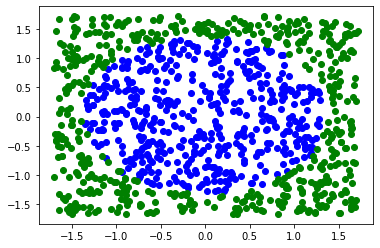

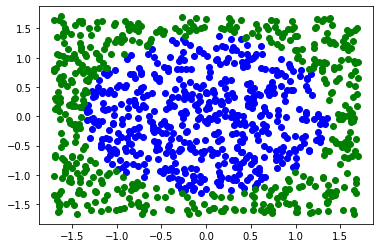

In [101]:
def generate_disc_set(nb):
    input_ = torch.rand(nb, 2)
    target = (input_-0.5).pow(2).sum(1).sub(1 / (math.pi*2)).sign().add(1).div(2).long()
    return input_, target
train_data, train_target= generate_disc_set(1000)
test_data,  test_target = generate_disc_set(1000)

train_target= 1 - train_target
test_target = 1 - test_target

#normalization
m=train_data.mean(0)
train_data-=m
std=train_data.std(0)
train_data/=std
test_data-=m
test_data/=std

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
plt.plot(train_data[:,0][train_target==1], train_data[:,1][train_target==1],'bo')
plt.plot(train_data[:,0][train_target!=1], train_data[:,1][train_target!=1],'go')

fig = plt.figure()
plt.plot(test_data[:,0][test_target==1], test_data[:,1][test_target==1],'bo')
plt.plot(test_data[:,0][test_target!=1], test_data[:,1][test_target!=1],'go')

In [102]:
#output_data = 2*output_data -1
print(train_data, train_data.shape, test_data.shape)

tensor([[ 1.3763, -1.1262],
        [ 1.5712,  1.3630],
        [ 0.8276,  0.6434],
        ...,
        [-0.4395,  0.5932],
        [ 0.8482, -1.4618],
        [-1.0121,  0.5934]]) torch.Size([1000, 2]) torch.Size([1000, 2])


In [103]:
#we should use one hot label embedding with MSELoss. Hence it is necessary to implement a Softmax
#Maybe we should also implement CrossEntropyLoss
#print(input_data.shape, output_data.shape)
#output_data = convert_to_one_hot_labels(input_data, output_data)
#print(input_data.shape, output_data.shape)

In [104]:
#handmade sequential linear + tanh
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = Tanh()
sigma2 = Tanh()
sigma3 = Tanh()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])

In [105]:
optimizer = SGD(lr = 1e-4, parameters = net.get_parameters())
n=10**2
N=train_data.shape[0]
for t in range(n):
    optimizer.zero_grad()
    acc_loss=0
    permuted_index = torch.randperm(train_data.size()[0])
    train_data_shuffled = train_data[permuted_index]
    train_target_shuffled = train_target[permuted_index]
    for i in range(N):
        x=train_data_shuffled[i]
        y=2*train_target_shuffled[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        acc_loss += loss.forward(y_pred,y.unsqueeze(0))
        
        net.backward(loss.backward())

    new_par = optimizer.step()
    net.set_parameters(new_par)
    
    
    if t%10==0:
        print(t, '   MSE loss = ' , acc_loss.item())

0    MSE loss =  1012.6871337890625
10    MSE loss =  963.845947265625
20    MSE loss =  926.9271240234375
30    MSE loss =  882.2239379882812
40    MSE loss =  825.8302001953125
50    MSE loss =  756.7952270507812
60    MSE loss =  679.033935546875
70    MSE loss =  600.1594848632812
80    MSE loss =  526.63037109375
90    MSE loss =  461.8247375488281


In [106]:
#counting corrects on test
correct_count=0
for i in range(test_data.shape[0]):
        x=test_data[i]
        y=2*test_target[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        
        correct = y_pred.sign()*y>0
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')

Correct predictions after 100 training steps: 95.5 %


In [107]:
#Reinitialize net
#handmade sequential linear + tanh
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = Tanh()
sigma2 = Tanh()
sigma3 = Tanh()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])

In [108]:
optimizer = SGD(lr = 1e-3,momentum=False, parameters = net.get_parameters())
n=10**2
N=train_data.shape[0]
batch_size = 100
for t in range(n):
    acc_loss=0
    permuted_index = torch.randperm(train_data.size()[0])
    train_data_shuffled = train_data[permuted_index]
    train_target_shuffled = train_target[permuted_index]
    for b in range(0, N, batch_size):
        predictions = net.forward(train_data_shuffled[b:b+batch_size])
        l= loss.forward(predictions, train_target_shuffled[b:b+batch_size].unsqueeze(-1))
        acc_loss += l
        optimizer.zero_grad()
        
        net.backward(loss.backward())
        
        new_par = optimizer.step()
        net.set_parameters(new_par)
    
    print(t, '   MSE loss = ' , acc_loss.item())

0    MSE loss =  4.342906475067139
1    MSE loss =  4.3405232429504395
2    MSE loss =  4.338143348693848
3    MSE loss =  4.335768699645996
4    MSE loss =  4.333393573760986
5    MSE loss =  4.331024169921875
6    MSE loss =  4.328657627105713
7    MSE loss =  4.326293468475342
8    MSE loss =  4.323933124542236
9    MSE loss =  4.3215742111206055
10    MSE loss =  4.3192219734191895
11    MSE loss =  4.316867828369141
12    MSE loss =  4.314519882202148
13    MSE loss =  4.3121747970581055
14    MSE loss =  4.3098320960998535
15    MSE loss =  4.307492256164551
16    MSE loss =  4.3051581382751465
17    MSE loss =  4.302823066711426
18    MSE loss =  4.300495147705078
19    MSE loss =  4.298166751861572
20    MSE loss =  4.295842170715332
21    MSE loss =  4.293521881103516
22    MSE loss =  4.291205406188965
23    MSE loss =  4.288888931274414
24    MSE loss =  4.286579132080078
25    MSE loss =  4.284268379211426
26    MSE loss =  4.281966209411621
27    MSE loss =  4.279660701751

In [109]:
#counting corrects on test
correct_count=0
for i in range(test_data.shape[0]):
        x=test_data[i]
        y=2*test_target[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        
        correct = y_pred.sign()*y>0
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')

Correct predictions after 100 training steps: 52.2 %


In [110]:
#handmade sequential linear + relu with sigmoid to end and no batches
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = ReLu()
sigma2 = ReLu()
sigma3 = Sigmoid()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])
optimizer = SGD(lr = 1e-4, parameters = net.get_parameters())
n=10**2
N=train_data.shape[0]
for t in range(n):
    optimizer.zero_grad()
    acc_loss=0
    permuted_index = torch.randperm(train_data.size()[0])
    train_data_shuffled = train_data[permuted_index]
    train_target_shuffled = train_target[permuted_index]
    for i in range(N):
        x=train_data_shuffled[i]
        y=train_target_shuffled[i]
        
        y_pred = net.forward(x.unsqueeze(0))
        
        acc_loss += loss.forward(y_pred,y.unsqueeze(0))
        
        net.backward(loss.backward())

    # Calling the step function on an Optimizer makes an update to its parameters
    new_par = optimizer.step()
    #print(len(new_par))
    net.set_parameters(new_par)
    
    
    if t%10==0:
        print(t, '   MSE loss = ' , acc_loss.item())
    
#counting corrects on test
correct_count=0
for i in range(test_data.shape[0]):
        x=test_data[i]
        y=2*test_target[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        
        correct = y_pred.sign()*y>0
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')

0    MSE loss =  259.2001037597656
10    MSE loss =  252.4178009033203
20    MSE loss =  247.98216247558594
30    MSE loss =  244.89903259277344
40    MSE loss =  242.5345001220703
50    MSE loss =  240.60292053222656
60    MSE loss =  238.91146850585938
70    MSE loss =  237.3318634033203
80    MSE loss =  235.78921508789062
90    MSE loss =  234.230224609375
Correct predictions after 100 training steps: 52.2 %


In [114]:
#handmade sequential linear + relu with softmax with batches
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = ReLu()
sigma2 = ReLu()
sigma3 = Sigmoid()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])
optimizer = SGD(lr = 1e-2, parameters = net.get_parameters())
n=10**2
N=train_data.shape[0]
batch_size = 100
for t in range(n):
    acc_loss=0
    permuted_index = torch.randperm(train_data.size()[0])
    train_data_shuffled = train_data[permuted_index]
    train_target_shuffled = train_target[permuted_index]
    for b in range(0, N, batch_size):
        predictions = net.forward(train_data_shuffled[b:b+batch_size])
        l= loss.forward(predictions,train_target_shuffled[b:b+batch_size].unsqueeze(-1))
        acc_loss += l
        optimizer.zero_grad()
        
        net.backward(loss.backward())
        
        new_par = optimizer.step()
        net.set_parameters(new_par)
    
    print(t, '   MSE loss = ' , acc_loss.item())
    
#counting corrects on test
correct_count=0
for i in range(test_data.shape[0]):
        x=test_data[i]
        y=2*test_target[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        
        correct = y_pred.sign()*y>0
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')

0    MSE loss =  2.5388693809509277
1    MSE loss =  2.5388174057006836
2    MSE loss =  2.538766384124756
3    MSE loss =  2.5387144088745117
4    MSE loss =  2.538663387298584
5    MSE loss =  2.5386128425598145
6    MSE loss =  2.5385611057281494
7    MSE loss =  2.538510322570801
8    MSE loss =  2.538458824157715
9    MSE loss =  2.538407325744629
10    MSE loss =  2.5383567810058594
11    MSE loss =  2.538306474685669
12    MSE loss =  2.538254737854004
13    MSE loss =  2.538203716278076
14    MSE loss =  2.538154125213623
15    MSE loss =  2.538102626800537
16    MSE loss =  2.538050889968872
17    MSE loss =  2.5380001068115234
18    MSE loss =  2.537949323654175
19    MSE loss =  2.537898540496826
20    MSE loss =  2.5378475189208984
21    MSE loss =  2.53779673576355
22    MSE loss =  2.5377464294433594
23    MSE loss =  2.5376956462860107
24    MSE loss =  2.537644863128662
25    MSE loss =  2.5375945568084717
26    MSE loss =  2.537544012069702
27    MSE loss =  2.53749322

In [121]:
#handmade sequential linear + relu with softmax with batches
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,2,True)
sigma1 = ReLu()
sigma2 = ReLu()
sigma3 = Softmax()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])
optimizer = SGD(lr = 1e-1, parameters = net.get_parameters())
n=10**2
N=train_data.shape[0]
batch_size = 100
for t in range(n):
    acc_loss=0
    permuted_index = torch.randperm(train_data.size()[0])
    train_data_shuffled = train_data[permuted_index]
    train_target_shuffled = torch.cat((train_target[permuted_index],1-train_target[permuted_index]),0)
    for b in range(0, N, batch_size):
        predictions = net.forward(train_data_shuffled[b:b+batch_size])
        l= loss.forward(predictions,train_target_shuffled[b:b+batch_size].unsqueeze(-1))
        acc_loss += l
        optimizer.zero_grad()
        
        net.backward(loss.backward())
        
        new_par = optimizer.step()
        net.set_parameters(new_par)
    
    print(t, '   MSE loss = ' , acc_loss.item())
    
#counting corrects on test
correct_count=0
for i in range(test_data.shape[0]):
        x=test_data[i]
        y=2*test_target[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        correct = (2*y_pred[0,0]-1).sign()*y>0
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')

0    MSE loss =  2.5383269786834717
1    MSE loss =  2.538085460662842
2    MSE loss =  2.5378453731536865
3    MSE loss =  2.537606716156006
4    MSE loss =  2.537370204925537
5    MSE loss =  2.537134885787964
6    MSE loss =  2.5369012355804443
7    MSE loss =  2.5366690158843994
8    MSE loss =  2.5364387035369873
9    MSE loss =  2.5362095832824707
10    MSE loss =  2.535982131958008
11    MSE loss =  2.5357565879821777
12    MSE loss =  2.535532236099243
13    MSE loss =  2.5353097915649414
14    MSE loss =  2.535088300704956
15    MSE loss =  2.5348687171936035
16    MSE loss =  2.5346503257751465
17    MSE loss =  2.5344338417053223
18    MSE loss =  2.5342183113098145
19    MSE loss =  2.5340046882629395
20    MSE loss =  2.53379225730896
21    MSE loss =  2.533581256866455
22    MSE loss =  2.533371686935425
23    MSE loss =  2.533163547515869
24    MSE loss =  2.532956838607788
25    MSE loss =  2.5327517986297607
26    MSE loss =  2.53254771232605
27    MSE loss =  2.532345